In [12]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os 
import json

In [2]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_' + string],'')
    plt.xlabel('Epochs')
    plt.ylabel(string)
    plt.legend([string, 'val_' + string])
    plt.show()

In [3]:
DATA_IN_PATH = './data_in/'
DATA_OUT_PATH = './data_out/'
INPUT_TRAIN_DATA = 'nsmc_train_input.npy'
LABEL_TRAIN_DATA = 'nsmc_train_label.npy'
DATA_CONFIGS = 'nsmc_data_configs.json'

In [4]:
SEED_NUM = 1234
tf.random.set_seed(SEED_NUM)

In [5]:
train_input = np.load(open(DATA_IN_PATH + INPUT_TRAIN_DATA, 'rb'))
train_label = np.load(open(DATA_IN_PATH + LABEL_TRAIN_DATA, 'rb'))
prepro_configs = json.load(open(DATA_IN_PATH + DATA_CONFIGS, 'r'))

In [6]:
model_name = 'cnn_classifier_kr'
BATCH_SIZE = 512
NUM_EPOCHS = 10
VALID_SPLIT = 0.1
MAX_LEN = train_input.shape[1]

kargs = {'model_name': model_name,
        'vocab_size': prepro_configs['vocab_size'],
        'embedding_size': 128,
        'num_filters': 100,
        'dropout_rate': 0.5,
        'hidden_dimension': 250,
        'output_dimension': 1}

In [7]:
class CNNClassifier(tf.keras.Model):
    def __init__(self, **kargs):
        super(CNNClassifier, self).__init__(name = kargs['model_name'])
        self.embedding = layers.Embedding(input_dim = kargs['vocab_size'] + 1,
                                          output_dim = kargs['embedding_size'])
        
        self.conv_list = [layers.Conv1D(filters = kargs['num_filters'], kernel_size = kernel_size,
                                        padding = 'valid', activation = 'relu',
                                        kernel_constraint = tf.keras.constraints.MaxNorm(max_value = 3.))  # 제약을 줌 ->
                         # 커널을 생성할때, 가중치값을 3을 못넘게 -> MaxNorm값을 줌 -> 스케일이 이 이상 커짖 ㅣ않게 제약을 준 것
                         for kernel_size in [3, 4, 5]]
        self.pooling = layers.GlobalMaxPooling1D()
        self.dropout = layers.Dropout(kargs['dropout_rate'])
        self.fc1 = layers.Dense(units = kargs['hidden_dimension'],
                                activation = 'relu',
                                kernel_constraint = tf.keras.constraints.MaxNorm(max_value = 3.))
        self.fc2 = layers.Dense(units = kargs['output_dimension'],
                                activation = 'sigmoid',
                                kernel_constraint = tf.keras.constraints.MaxNorm(max_value = 3.))
        
    def call(self, x):   # call 함수 생성.  call만 만들면 됨
        x = self.embedding(x)
        x = self.dropout(x)
        # p199 에서 출력을 각각 maxpooling하고 붙임 그걸 다음과 같은 문법으로 나타냄
        x = tf.concat([self.pooling(conv(x)) for conv in self.conv_list], axis = -1)  # inerconfresion 문법?
        # conv를 각각 넣어서 list로 만들고 그것을 concat함.  axis = -1방향으로
        x = self.fc1(x)
        x = self.fc2(x)
        
        return x

In [8]:
model = CNNClassifier(**kargs)
model.compile(optimizer = tf.keras.optimizers.Adam(),
             loss = tf.keras.losses.BinaryCrossentropy(),
             metrics = [tf.keras.metrics.BinaryAccuracy(name = 'accuracy')])

In [9]:
# import os

earlystop_callback = EarlyStopping(monitor = 'val_accuracy', min_delta = 0.0001, patience = 2)

checkpoint_path = DATA_OUT_PATH + model_name + '/weights.h5'
checkpoint_dir = os.path.dirname(checkpoint_path)

if os.path.exists(checkpoint_dir):
    print('{} -- Folder already exists \n'.format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok = True)
    print('{} -- Folder create complete \n'.format(checkpoint_dir))
    
cp_callback = ModelCheckpoint(checkpoint_path, monitor = 'val_accuracy', verbose = 1, save_best_only = True,
                              save_weights_only = True)

./data_out/cnn_classifier_kr -- Folder already exists 



In [10]:
history = model.fit(train_input, train_label, batch_size = BATCH_SIZE, epochs = NUM_EPOCHS,
                    validation_split = VALID_SPLIT, callbacks = [earlystop_callback, cp_callback])

Epoch 1/10
264/264 [==============================] - 30s 61ms/step - loss: 0.4581 - accuracy: 0.7760 - val_loss: 0.3950 - val_accuracy: 0.8227

Epoch 00001: val_accuracy improved from -inf to 0.82267, saving model to ./data_out/cnn_classifier_kr\weights.h5
Epoch 2/10
264/264 [==============================] - 6s 22ms/step - loss: 0.3517 - accuracy: 0.8455 - val_loss: 0.3858 - val_accuracy: 0.8291

Epoch 00002: val_accuracy improved from 0.82267 to 0.82907, saving model to ./data_out/cnn_classifier_kr\weights.h5
Epoch 3/10
264/264 [==============================] - 4s 17ms/step - loss: 0.3002 - accuracy: 0.8726 - val_loss: 0.4013 - val_accuracy: 0.8207

Epoch 00003: val_accuracy did not improve from 0.82907
Epoch 4/10
264/264 [==============================] - 4s 17ms/step - loss: 0.2565 - accuracy: 0.8933 - val_loss: 0.4228 - val_accuracy: 0.8191

Epoch 00004: val_accuracy did not improve from 0.82907


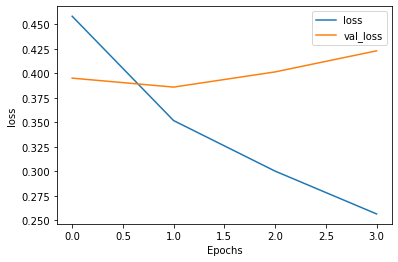

In [13]:
plot_graphs(history, 'loss')

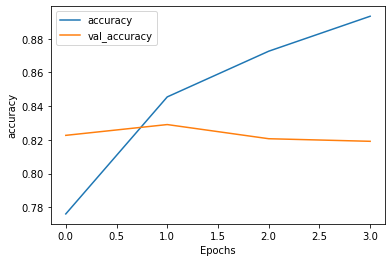

In [14]:
plot_graphs(history, 'accuracy')

In [ ]:
# test data 의 label이 없어서 어쩔 수 없이 캐글에 올려서채점을 했으나,
# 여기선 있으므로 직접 채점을 할 수 있다.

In [15]:
INPUT_TEST_DATA = 'nsmc_test_input.npy'
LABEL_TEST_DATA = 'nsmc_test_label.npy'
SAVE_FILE_NM = 'weights.h5'

test_input = np.load(open(DATA_IN_PATH + INPUT_TEST_DATA, 'rb'))
test_label_data = np.load(open(DATA_IN_PATH + LABEL_TEST_DATA, 'rb'))

In [16]:
# 모델 가중치 불러오기
model.load_weights(os.path.join(DATA_OUT_PATH, model_name, SAVE_FILE_NM))

In [17]:
model.evaluate(test_input, test_label_data)

1563/1563 [==============================] - 18s 11ms/step - loss: 0.3879 - accuracy: 0.8255


[0.38794130086898804, 0.8255400061607361]